In [41]:
from PyQt6.QtWidgets import QApplication, QFileDialog
import sys

def select_folder_pyqt6():
    # Create application
    app = QApplication(sys.argv)

    # Open folder dialog
    folder_path = QFileDialog.getExistingDirectory(
        None,
        "Select a folder",
        ""
    )

    # Close QApplication
    app.exit()

    return folder_path

path = select_folder_pyqt6()
print(f"path: {path}")

path: X:/Anlagen/_lab31316-nlo/Inbox/experiment/202511_NLO_measurement_results/20251218_1730_BMF36-B0_d32_rotation


### Select fitting strategy

In [42]:
from shg_analysis import SHGDataAnalysis
from crystaldatabase import CRYSTALS
from crystaldatabase import *

analysis = SHGDataAnalysis(path)
meta = analysis.meta
data = analysis.data

crystal = CRYSTALS[meta["material"]]()

if crystal.axiality == "uniaxial":
    from fitting_strategies.jerphagnon1970 import Jerphagnon1970Strategy
    strategy = Jerphagnon1970Strategy(analysis)

elif crystal.axiality == "biaxial":
    from fitting_strategies.ishidate1974 import Ishidate1974Strategy
    strategy = Ishidate1974Strategy(analysis)

In [43]:
fringe = strategy._maker_fringes(override={"theta_deg":data["position"]})
envelope = strategy._maker_fringes(override={"theta_deg":data["position"]}, envelope=True)

x = analysis.data["position"]
intensity_corrected = analysis.data["intensity_corrected"]

### theoretical fringe before fitting

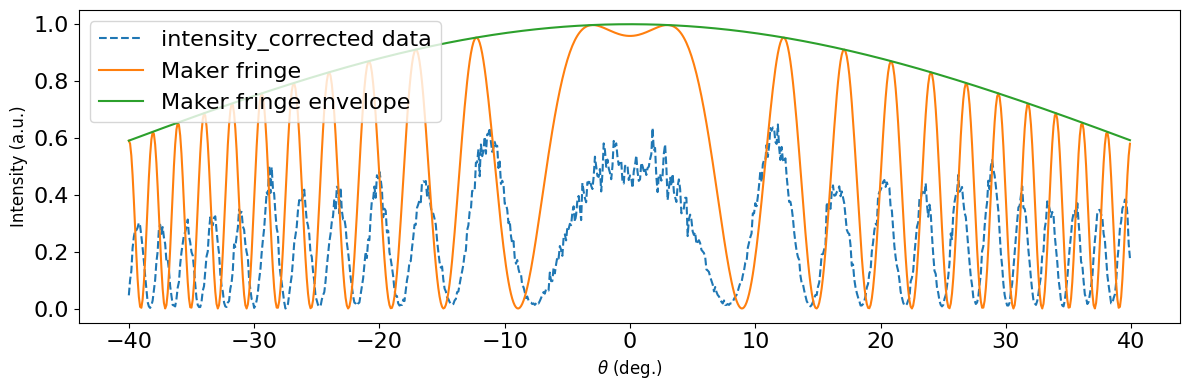

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, intensity_corrected, label='intensity_corrected data', linestyle='--')
ax.plot(x, fringe, label='Maker fringe')
ax.plot(x, envelope, label='Maker fringe envelope')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)

# ax.set_xlim(-20, 20)
if np.max(envelope) > 10.0:
      ax.set_ylim(0, 10)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()

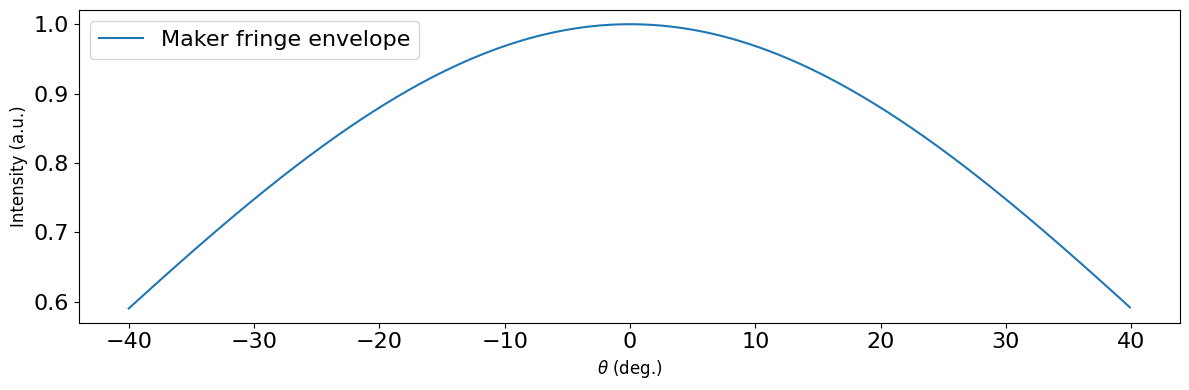

In [45]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, envelope, label='Maker fringe envelope')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)
# ax.set_yscale("log")

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()

In [46]:
try:
    results = strategy.fit_all()
except Exception as e:
    print(f"Error:{e}")
# results = strategy.fit_all()

### Offset subtraction

offset:  0.008008675886069776


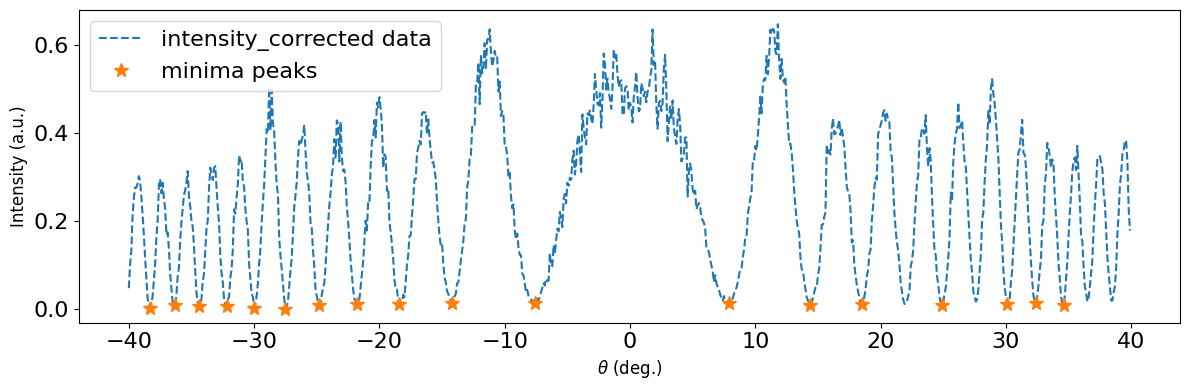

In [47]:
_, fit_offset = strategy._subtract_offset(analysis.data)
minima_x = x[fit_offset["minima_idx"]]
minima_y = intensity_corrected[fit_offset["minima_idx"]]
offset = fit_offset["offset"]
print("offset: ",offset)


plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, intensity_corrected, label='intensity_corrected data', linestyle='--')
ax.plot(minima_x, minima_y, "*", ms=10, label='minima peaks')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)

# ax.set_xlim(-20, 20)
# ax.set_ylim(-0.1, 3.2)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()


In [48]:
print(minima_x)

17    -38.3
37    -36.3
56    -34.4
78    -32.2
100   -30.0
125   -27.5
152   -24.8
182   -21.8
216   -18.4
258   -14.2
324    -7.6
479     7.9
544    14.4
585    18.5
649    24.9
701    30.1
724    32.4
746    34.6
Name: position, dtype: float64


### Position centering fit

center position:  0.06804000000000099


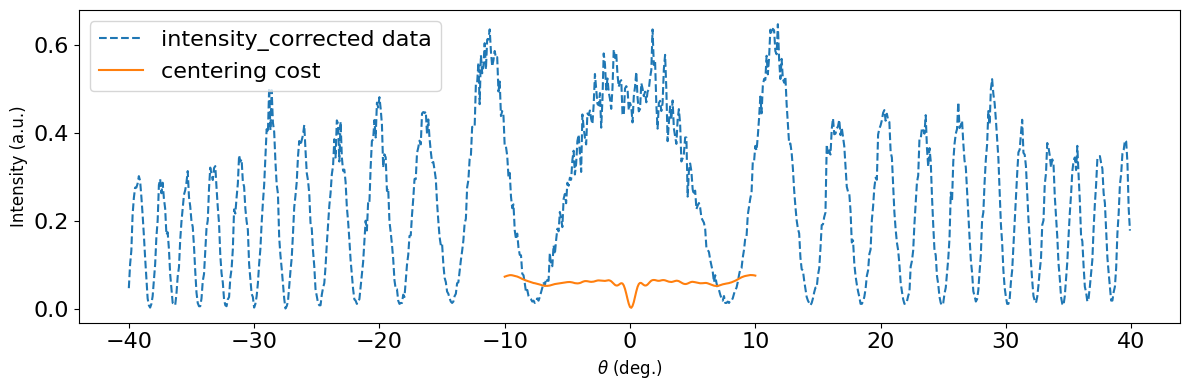

In [49]:
_, fit_centering = strategy._position_centering(analysis.data)
center_x = fit_centering["c_candidates"]
center_cost = fit_centering["costs"]
center = fit_centering["c_best"]
print("center position: ",center)


plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, intensity_corrected, label='intensity_corrected data', linestyle='--')
ax.plot(center_x, center_cost, label='centering cost')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)

# ax.set_xlim(-20, 20)
# ax.set_ylim(0, 3.2)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()


### sample thickness fitting

In [50]:
L_fit = strategy._fit_L_small_angle(meta, analysis.data)
print(f"measured thickness:{analysis.meta["thickness_info"]["t_at_thin_end_mm"]}")
print(L_fit)

L_override = L_fit["L_mm"]

measured thickness:1.389
{'L_mm': 1.3917675297631924, 'L_mm_std': 0.00019591826256009384, 'k_scale': 0.5223896157758565, 'k_scale_std': 0.011692816995457244}


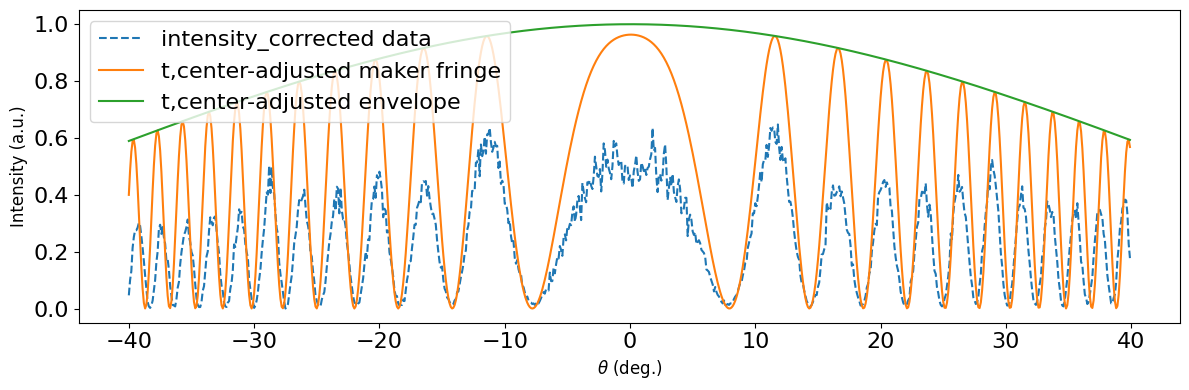

In [51]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

L_fitted_fringe = strategy._maker_fringes(override={"L":L_override, "theta_deg": x - center})
L_fitted_envelope = strategy._maker_fringes(envelope=True, override={"L":L_override, "theta_deg": x - center})

ax.plot(x, intensity_corrected, label='intensity_corrected data', linestyle='--')
ax.plot(x, L_fitted_fringe, label='t,center-adjusted maker fringe')
ax.plot(x, L_fitted_envelope, label='t,center-adjusted envelope')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)

# ax.set_xlim(-20, 20)
if np.max(L_fitted_envelope) > 15.0:
      ax.set_ylim(0, 12)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()

### Calculate Lc

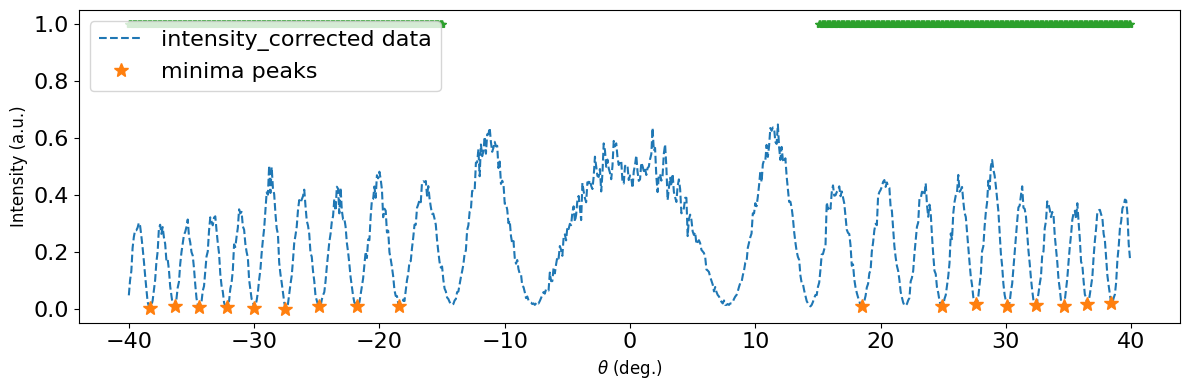

[0.0157575  0.00769429 0.00759332 0.00733321 0.00728107 0.00646461
 0.00659822]
[0.00694443 0.00645961 0.00727411 0.00701275 0.0075994  0.00770176
 0.00786083 0.00791775]
[array([0.0157575 , 0.00769429, 0.00759332, 0.00733321, 0.00728107,
       0.00646461, 0.00659822]), array([0.00694443, 0.00645961, 0.00727411, 0.00701275, 0.0075994 ,
       0.00770176, 0.00786083, 0.00791775])]


In [52]:
try:
    _, fit_Lc = strategy._calc_Lc_large_angle(analysis.meta, analysis.data, [15,180], L_fit["L_mm"])
   
    minima_x = x[fit_Lc["minima_idx"]]
    minima_y = intensity_corrected[fit_Lc["minima_idx"]]

    theta_in_range = x[fit_Lc["x_in_range"]]
    y = [1 for i in theta_in_range]


    plt.rcParams['font.size'] = 10
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(x, intensity_corrected, label='intensity_corrected data', linestyle='--')
    ax.plot(minima_x, minima_y, "*", ms=10, label='minima peaks')
    ax.plot(theta_in_range, y, "*")

    ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
    ax.set_ylabel('Intensity (a.u.)', fontsize=12)

    # ax.set_xlim(-20, 20)
    # ax.set_ylim(-0.1, 3.2)

    fig.tight_layout()
    ax.legend(loc='upper left')
    plt.show()

    print(fit_Lc["dL_pos"])
    print(fit_Lc["dL_neg"])
    print(fit_Lc["parts"])

except Exception as e:
    print(f"Error during '_calc_Lc_large_angle':{e}")


### Intensity fit

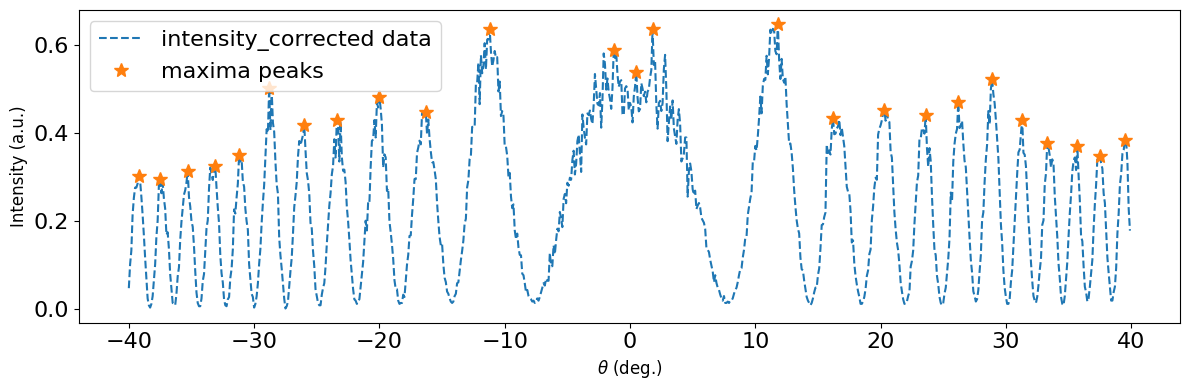

In [53]:
fit_results, fit_Pm0 = strategy._fit_Pm0(analysis.data)
maxima_x = x[fit_Pm0["maxima_idx"]]
maxima_y = intensity_corrected[fit_Pm0["maxima_idx"]]


plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, intensity_corrected, label='intensity_corrected data', linestyle='--')
ax.plot(maxima_x, maxima_y, "*", ms=10, label='maxima peaks')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)

# ax.set_xlim(-20, 20)
# ax.set_ylim(0.0, 4)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()


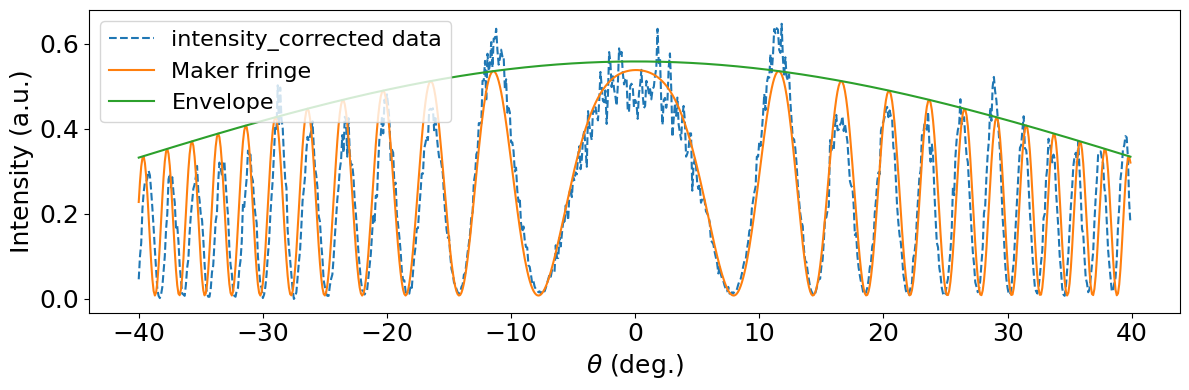

In [54]:
k = fit_results["Pm0"]
L = L_fit["L_mm"]
position_centered = strategy.analysis.data["position_centered"]


fitted_fringe = k * strategy._maker_fringes(override={"L":L, "theta_deg": position_centered}) \
      + offset

fitted_envelope = k * strategy._maker_fringes(envelope=True, override={"L":L, "theta_deg": position_centered}) \
      + offset

plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, intensity_corrected, label='intensity_corrected data', linestyle='--')
ax.plot(position_centered + center, fitted_fringe, label='Maker fringe')
ax.plot(position_centered + center, fitted_envelope, label='Envelope')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=18)
ax.set_ylabel('Intensity (a.u.)', fontsize=18)

ax.tick_params(axis="both", labelsize=18)

# ax.set_xlim(-20, 20)
if np.max(fitted_envelope) > 10.0:
      ax.set_ylim(0, 10)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()

### Change L manually for better fitting

In [62]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# ---- Plot style control (single variable) ----
ft = 16  # Change this to scale everything

plt.rcParams.update({
    "font.size": ft,
    "axes.titlesize": ft,
    "axes.labelsize": ft,
    "xtick.labelsize": ft,
    "ytick.labelsize": ft,
    "legend.fontsize": ft,
})

# ---- Angle axis ----
theta_deg = position_centered

# ---- L settings ----
L0_mm = analysis.meta["thickness_info"]["t_at_thin_end_mm"]  # <-- set your nominal L here [mm]
dL_um = 10.0   # +/- range [um]
dL_mm = dL_um / 1000.0

slider = widgets.FloatSlider(
    value=0.0,
    min=-dL_um,
    max=+dL_um,
    step=0.1,
    description="ΔL (µm)",
    continuous_update=True,
    readout=True,
    readout_format=".1f",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="650px"),
)
btn_reset = widgets.Button(description="Reset", layout=widgets.Layout(width="120px"))

out = widgets.Output()

def redraw(dL_current_um: float):
    L_mm = L0_mm + dL_current_um / 1000.0
    y_on_L = k * strategy._maker_fringes(override={"L":L_mm, "theta_deg": position_centered}) \
      + offset

    with out:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(theta_deg, y_on_L, lw=2, label="Maker fringe (model)")
        ax.plot(theta_deg, intensity_corrected, label='intensity_corrected data', linestyle='--')
        ax.set_title("Maker fringe vs incidence angle")
        ax.set_xlabel("Incidence angle (deg)")
        ax.set_ylabel("Normalized intensity (a.u.)")
        # ax.set_xlim(theta_min, theta_max)
        # ax.set_ylim(-0.05, 1.05)
        ax.grid(True)
        ax.text(
            0.02, 0.95,
            f"L = {L_mm:.6f} mm  (ΔL = {dL_current_um:+.1f} µm)",
            transform=ax.transAxes,
            va="top",
            ha="left",
        )
        ax.legend(loc="upper right")
        plt.show()

def _on_slider_change(change):
    redraw(change["new"])

def _on_reset(_):
    slider.value = 0.0

slider.observe(_on_slider_change, names="value")
btn_reset.on_click(_on_reset)

display(widgets.HBox([slider, btn_reset]))
display(out)

# Initial draw
redraw(slider.value)

Output()

### minima/maxima detection trial

estimated index: 6 period :13.333333333333524


C:\Users\ui\AppData\Local\Temp\ipykernel_9084\1629006177.py:14: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freq, fft, "-")


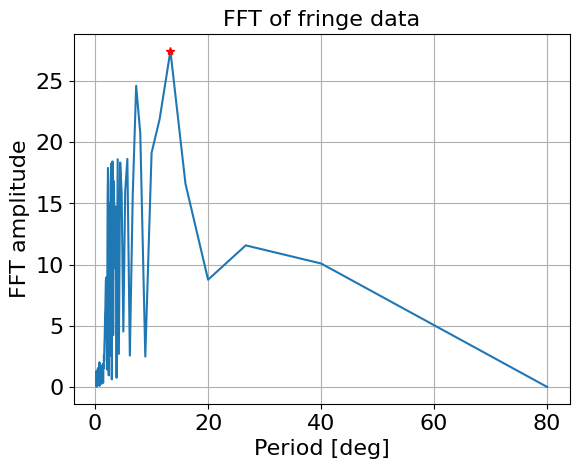

dx ~ 0.1 deg, suggested window length ~ 45 samples


In [56]:
x = data["position_centered"]
y = data["offset_corrected"]

try:
    if x is None or y is None:
        raise RuntimeError("x/y is None.")

    period, idx, freq, fft = strategy.estimate_fringe_period(x, y)
    fft = np.abs(fft)

    print(f"estimated index: {idx} period :{period}")

    plt.figure()
    plt.plot(1/freq, fft, "-")
    plt.plot(1/freq[idx], fft[idx], "*", color="r")
    plt.xlabel("Period [deg]")
    plt.ylabel("FFT amplitude")
    plt.title("FFT of fringe data")
    # plt.xlim(0, 0.1)
    # plt.yscale("log")
    plt.grid(True)
    plt.show()

    # Also print an approximate window length suggestion, if period is valid
    if period is not None:
        dx = float(np.median(np.diff(x)))
        window = int((period / dx) / 3)
        if window < 5:
            window = 5
        if window % 2 == 0:
            window += 1
        print(f"dx ~ {dx:.6g} deg, suggested window length ~ {window} samples")

except Exception as e:
    print("estimate_fringe_period failed:", repr(e))

### Theoretical fringe for different thickness

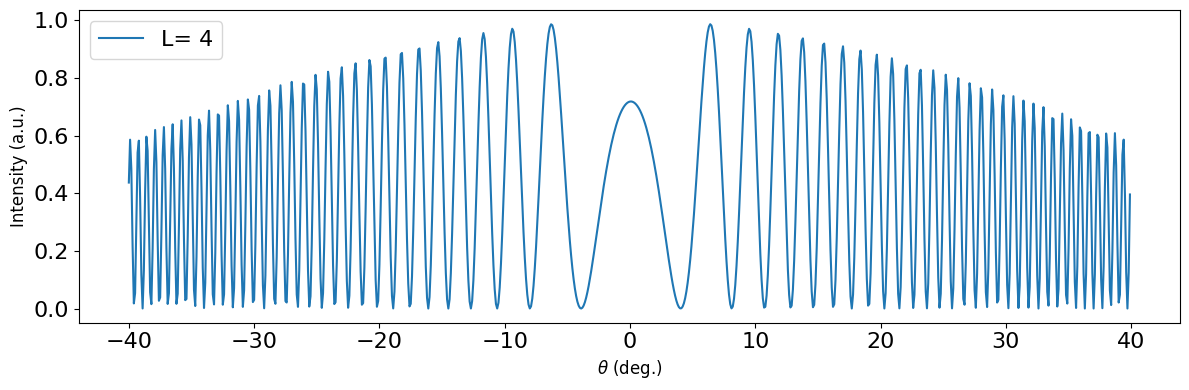

In [57]:
meta = analysis.meta
data = analysis.data

x = analysis.data["position"]
intensity_corrected = analysis.data["intensity_corrected"]

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(12, 4))

for i in [4]:
    fringe = strategy._maker_fringes(override={"L":i})
    # envelope = strategy._maker_fringes(override={"L":i}, envelope=True)
    ax.plot(x, fringe, label=f'L= {i}')
    # ax.plot(x, envelope, label=f'envelope at L={i}')

ax.set_xlabel(r'$\theta$ (deg.)', fontsize=12)
ax.set_ylabel('Intensity (a.u.)', fontsize=12)

# ax.set_xlim(-20, 20)
# ax.set_ylim(0, 3.2)

fig.tight_layout()
ax.legend(loc='upper left')
plt.show()

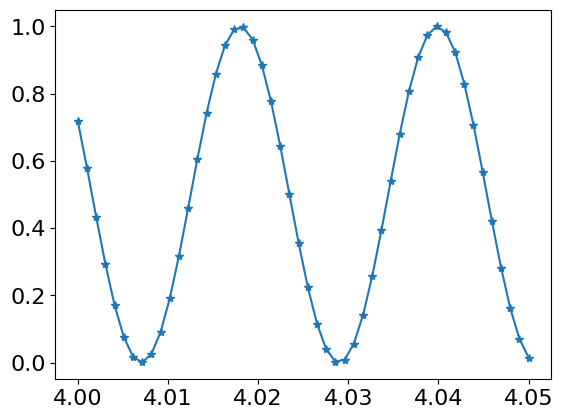

In [58]:
x = np.linspace(4, 4.05, 50)
y = []
for i in x:
    fringe = strategy._maker_fringes(override={"L":i, "theta_deg":center})
    y.append(fringe)

plt.plot(x, y, "-*")
plt.show()